# CheXpert : A Large Chest X-Ray Dataset and Competition

This competition launched by the Stanford ML group aims at finding a prediction model which could perform as well as radiologist to find different pathologies thanks to chest X-Ray. The Dataset available to train our model is composed of 223,414 chest radiographs of 65,240 patients.

<img src="view1_frontal.jpg" title="X-Ray image of the dataset" width = 320/>

The website of the competition:
https://stanfordmlgroup.github.io/competitions/chexpert/

[Publication](https://arxiv.org/pdf/1901.07031.pdf) : Irvin, Jeremy, et al. "CheXpert: A Large Chest Radiograph Dataset with Uncertainty Labels and Expert Comparison." arXiv preprint arXiv:1901.07031 (2019).

Our goal is first to reproduce main results obtained in the related paper, published in January 2019.

In [1]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image
import torch.nn.functional as func

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import sklearn.metrics as metrics
import random

use_gpu = torch.cuda.is_available()

In [2]:
# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
pathFileTrain = '/scratch/ssriva94/Capstone/archive/CheXpert-v1.0-small/train.csv'
pathFileValid = '/scratch/ssriva94/Capstone/archive/CheXpert-v1.0-small/valid.csv'

# Neural network parameters:
nnIsTrained = False                 #pre-trained using ImageNet
nnClassCount = 14                   #dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 64
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

## 1. Create a Dataset

In this first part, we create a loader able to load the data thanks to the csv files of the dataset.
This loader first load labels and paths to the different images.

It includes a pre-processing of labels to deal with uncertainty labels.
Indeed, four different labels exist:
-  **Blanks ('')**: the existence of the pathology is unknown
-  **Ones (1)**: the pathology is detected thanks to the image
-  **Zeros (0)**: the pathology can't be detected thanks to the image
-  **Uncertain (-1)**: the pathology may be detected.

In order to deal with uncertainty labels, different policies can be applied. The easiest ones consists in changing those **Uncertain** labels to *Blanks*, *Ones* or *Zeros*. This process is done thanks to the following class.

In [3]:
class CheXpertDataSet(Dataset):
    def __init__(self, image_list_file, transform=None, policy="ones"):
        """
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels
        """
        image_names = []
        labels = []

        with open(image_list_file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                image_name= line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                image_names.append('' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

## 2. Create DataLoaders

First we define a transform model to resize all images and normalize them.

In [4]:
#TRANSFORM DATA

normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
transformList = []
#transformList.append(transforms.Resize(imgtransCrop))
transformList.append(transforms.RandomResizedCrop(imgtransCrop))
transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
transformList.append(normalize)      
transformSequence=transforms.Compose(transformList)

Then we build train, validation and test data loaders. 

In [5]:
#LOAD DATASET

dataset = CheXpertDataSet(pathFileTrain ,transformSequence, policy="ones")
datasetTest, datasetTrain = random_split(dataset, [500, len(dataset) - 500])
datasetValid = CheXpertDataSet(pathFileValid, transformSequence)            
#Problèmes de l'overlapping de patients et du transform identique ?

dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=trBatchSize, shuffle=True,  num_workers=24, pin_memory=True)
dataLoaderVal = DataLoader(dataset=datasetValid, batch_size=trBatchSize, shuffle=False, num_workers=24, pin_memory=True)
dataLoaderTest = DataLoader(dataset=datasetTest, num_workers=24, pin_memory=True)

/home/ssriva94/.conda/envs/tab/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 3. Create train and test Models

We create here a class **CheXpertTrainer** to handle the train and test processes.

In [6]:
class CheXpertTrainer():

    def train (model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, launchTimestamp, checkpoint):
        
        #SETTINGS: OPTIMIZER & SCHEDULER
        optimizer = optim.Adam (model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
                
        #SETTINGS: LOSS
        loss = torch.nn.BCELoss(size_average = True)
        
        #LOAD CHECKPOINT 
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])

        
        #TRAIN THE NETWORK
        lossMIN = 100000
        
        for epochID in range(0, trMaxEpoch):
            
            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampSTART = timestampDate + '-' + timestampTime
            
            batchs, losst, losse = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            lossVal = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)


            timestampTime = time.strftime("%H%M%S")
            timestampDate = time.strftime("%d%m%Y")
            timestampEND = timestampDate + '-' + timestampTime
            
            if lossVal < lossMIN:
                lossMIN = lossVal    
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 'm-epoch'+str(epochID)+ '.pth.tar')
                print ('Epoch [' + str(epochID + 1) + '] [save] [' + timestampEND + '] loss= ' + str(lossVal))
            else:
                print ('Epoch [' + str(epochID + 1) + '] [----] [' + timestampEND + '] loss= ' + str(lossVal))
        
        return batchs, losst, losse        
    #-------------------------------------------------------------------------------- 
       
    def epochTrain(model, dataLoader, optimizer, epochMax, classCount, loss):
        
        batch = []
        losstrain = []
        losseval = []
        
        model.train()

        for batchID, (varInput, target) in enumerate(dataLoaderTrain):
            
            varTarget = target.cuda(non_blocking = True)
            
            #varTarget = target.cuda()         


            varOutput = model(varInput)
            lossvalue = loss(varOutput, varTarget)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            l = lossvalue.item()
            losstrain.append(l)
            
            if batchID%35==0:
                print(batchID//35, "% batches computed")
                #Fill three arrays to see the evolution of the loss


                batch.append(batchID)
                
                le = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss).item()
                losseval.append(le)
                
                print(batchID)
                print(l)
                print(le)
                
        return batch, losstrain, losseval
    
    #-------------------------------------------------------------------------------- 
    
    def epochVal(model, dataLoader, optimizer, epochMax, classCount, loss):
        
        model.eval()
        
        lossVal = 0
        lossValNorm = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):
                
                target = target.cuda(non_blocking = True)
                varOutput = model(varInput)
                
                losstensor = loss(varOutput, target)
                lossVal += losstensor
                lossValNorm += 1
                
        outLoss = lossVal / lossValNorm
        return outLoss
    
    
    #--------------------------------------------------------------------------------     
     
    #---- Computes area under ROC curve 
    #---- dataGT - ground truth data
    #---- dataPRED - predicted data
    #---- classCount - number of classes
    
    def computeAUROC (dataGT, dataPRED, classCount):
        
        outAUROC = []
        
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC
        
        
    #-------------------------------------------------------------------------------- 
    
    
    def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):   
            cudnn.benchmark = True
            
            if checkpoint != None and use_gpu:
                modelCheckpoint = torch.load(checkpoint)
                model.load_state_dict(modelCheckpoint['state_dict'])
    
            if use_gpu:
                outGT = torch.FloatTensor().cuda()
                outPRED = torch.FloatTensor().cuda()
            else:
                outGT = torch.FloatTensor()
                outPRED = torch.FloatTensor()
           
            model.eval()
            
            with torch.no_grad():
                for i, (input, target) in enumerate(dataLoaderTest):
                    target = target.cuda()
                    outGT = torch.cat((outGT, target), 0).cuda()
                    bs, c, h, w = input.size()
                    varInput = input.view(-1, c, h, w)            
                    out = model(varInput)
                    outPRED = torch.cat((outPRED, out), 0)
            
            # Convert to numpy arrays on CPU
            y_true = outGT.cpu().numpy()
            y_pred = outPRED.cpu().numpy()
            
            # Apply threshold for binary classification metrics
            y_pred_binary = (y_pred > 0.5).astype(int)
    
            # Calculate metrics for each class
            precision = precision_score(y_true, y_pred_binary, average=None, zero_division=0)
            recall = recall_score(y_true, y_pred_binary, average=None, zero_division=0)
            f1 = f1_score(y_true, y_pred_binary, average=None, zero_division=0)
    
            # Calculate macro averages
            precision_macro = precision_score(y_true, y_pred_binary, average='macro', zero_division=0)
            recall_macro = recall_score(y_true, y_pred_binary, average='macro', zero_division=0)
            f1_macro = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)
    
            # Calculate weighted averages
            precision_weighted = precision_score(y_true, y_pred_binary, average='weighted', zero_division=0)
            recall_weighted = recall_score(y_true, y_pred_binary, average='weighted', zero_division=0)
            f1_weighted = f1_score(y_true, y_pred_binary, average='weighted', zero_division=0)
    
            # Create metrics table
            metrics_df = pd.DataFrame({
                'Class': class_names,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1
            })
    
            # Add average rows
            avg_row = pd.DataFrame([['Macro Average', precision_macro, recall_macro, f1_macro]],
                                   columns=metrics_df.columns)
            metrics_df = pd.concat([metrics_df, avg_row], ignore_index=True)
            
            weighted_row = pd.DataFrame([['Weighted Average', precision_weighted, recall_weighted, f1_weighted]],
                                        columns=metrics_df.columns)
            metrics_df = pd.concat([metrics_df, weighted_row], ignore_index=True)
    
            # Format the table
            metrics_df = metrics_df.round(3)
            print("\nClassification Metrics Table:")
            print(metrics_df.to_markdown(index=False))
            
            # Save to CSV
            metrics_df.to_csv('classification_metrics.csv', index=False)
            print("\nMetrics saved to classification_metrics.csv")
    
            # Existing AUROC calculations
            aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
            aurocMean = np.array(aurocIndividual).mean()
            
            print('\nAUROC mean ', aurocMean)
            for i in range(len(aurocIndividual)):
                print(class_names[i], ' ', aurocIndividual[i])
            
            return outGT, outPRED

## 4. Train the model

In this part, we train the model and plot the loss curve.

In [7]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

In [8]:
# initialize and load the model
model = DenseNet121(nnClassCount).cuda()
model = torch.nn.DataParallel(model).cuda()

/home/ssriva94/.conda/envs/tab/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ssriva94/.conda/envs/tab/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
timestampTime = time.strftime("%H%M%S")
timestampDate = time.strftime("%d%m%Y")
timestampLaunch = timestampDate + '-' + timestampTime

batch, losst, losse = CheXpertTrainer.train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, timestampLaunch, checkpoint=None)
print("Model trained")

/home/ssriva94/.conda/envs/tab/lib/python3.11/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


0 % batches computed
0
0.6624164581298828
0.658269464969635
1 % batches computed
35
0.41441604495048523
0.4269999861717224
2 % batches computed
70
0.40901464223861694
0.4342401921749115
3 % batches computed
105
0.4012073874473572
0.4191609025001526
4 % batches computed
140
0.4037262499332428
0.4015844166278839
5 % batches computed
175
0.38493430614471436
0.4066316485404968
6 % batches computed
210
0.3853210508823395
0.4151560664176941
7 % batches computed
245
0.4067695438861847
0.4184294641017914
8 % batches computed
280
0.4111998677253723
0.4062654376029968
9 % batches computed
315
0.41902753710746765
0.40355074405670166
10 % batches computed
350
0.39630433917045593
0.41715550422668457
11 % batches computed
385
0.3861444592475891
0.39740070700645447
12 % batches computed
420
0.41707903146743774
0.40085169672966003
13 % batches computed
455
0.3633400797843933
0.38852769136428833
14 % batches computed
490
0.398454487323761
0.4119564890861511
15 % batches computed
525
0.3768547773361206


## 5. Test and ROC Curves

## In this part, we test our different models on a test set.

## We also plot the ROC Curves (Receiver operating characteristic).
## The metric used to evaluate the performances of our model is the AUROC : **Area Under The Roc Curve**.

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score
import torch
import torch.backends.cudnn as cudnn

def find_optimal_threshold(y_true, y_scores):
    """Find optimal threshold using Youden's J statistic."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Prevent issues with small sample sizes
    if len(thresholds) > 1:
        optimal_idx = np.argmax(tpr - fpr)  # Youden's J statistic
        optimal_threshold = thresholds[optimal_idx]
    else:
        optimal_threshold = 0.5  # Fallback in case of insufficient data
    
    return optimal_threshold


def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):   
    cudnn.benchmark = True
    
    if checkpoint and use_gpu:
        modelCheckpoint = torch.load(checkpoint)
        model.load_state_dict(modelCheckpoint['state_dict'])

    outGT = torch.FloatTensor().cuda() if use_gpu else torch.FloatTensor()
    outPRED = torch.FloatTensor().cuda() if use_gpu else torch.FloatTensor()
   
    model.eval()
    
    with torch.no_grad():
        for input, target in dataLoaderTest:
            target = target.cuda()
            outGT = torch.cat((outGT, target), 0)
            varInput = input.view(-1, *input.size()[-3:])            
            out = model(varInput)
            outPRED = torch.cat((outPRED, out), 0)
    
    # Convert to numpy arrays
    y_true = outGT.cpu().numpy()
    y_pred = outPRED.cpu().numpy()
    
    # Calculate optimal thresholds per class using Youden's J statistic
    optimal_thresholds = []
    for i in range(nnClassCount):
        fpr, tpr, thresholds = metrics.roc_curve(y_true[:,i], y_pred[:,i])
        J = tpr - fpr
        ix = np.argmax(J)
        optimal_thresholds.append(thresholds[ix])
    
    # Calculate metrics with class-specific optimal thresholds
    y_pred_optimal = (y_pred >= optimal_thresholds).astype(int)
    
    precision = precision_score(y_true, y_pred_optimal, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred_optimal, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred_optimal, average=None, zero_division=0)
    
    # Calculate weighted averages
    precision_weighted = precision_score(y_true, y_pred_optimal, average='weighted', zero_division=0)
    recall_weighted = recall_score(y_true, y_pred_optimal, average='weighted', zero_division=0)
    f1_weighted = f1_score(y_true, y_pred_optimal, average='weighted', zero_division=0)
    
    # AUC calculations
    aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
    aurocMean = np.mean(aurocIndividual)
    auroc_weighted = np.average(aurocIndividual, weights=y_true.sum(axis=0))

    # Create metrics table
    metrics_df = pd.DataFrame({
        'Class': class_names,
        'Optimal Threshold': [f"{t:.3f}" for t in optimal_thresholds],
        'PPV (Precision)': precision,
        'Recall': recall,
        'F1': f1,
        'AUC': [f"{score:.3f}" for score in aurocIndividual]
    })
    
    # Add summary rows
    metrics_df = pd.concat([
        metrics_df,
        pd.DataFrame([[
            'Weighted Average',
            '-',
            round(precision_weighted, 3),
            round(recall_weighted, 3),
            round(f1_weighted, 3),
            round(auroc_weighted, 3)
        ]], columns=metrics_df.columns)
    ])

    print("\nComprehensive Metrics with Optimal Thresholds:")
    print(metrics_df.to_markdown(index=False))
    
    return outGT, outPRED

# ✅ Define your class names
class_names = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]

# 🔥 Run the test function with per-class optimal thresholds
outGT1, outPRED1 = test(model, dataLoaderTest, nnClassCount, "m-epoch0.pth.tar", class_names)
outGT3, outPRED3 = test(model, dataLoaderTest, nnClassCount, "m-epoch2.pth.tar", class_names)


/tmp/ipykernel_2330268/2607765110.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelCheckpoint = torch.load(checkpoint)
/home/ssriva94/.conda/envs/tab/lib/python3.11


Comprehensive Metrics with Optimal Thresholds:
| Class                      | Optimal Threshold   |   PPV (Precision) |   Recall |       F1 |   AUC |
|:---------------------------|:--------------------|------------------:|---------:|---------:|------:|
| No Finding                 | 0.063               |         0.237569  | 0.86     | 0.372294 | 0.84  |
| Enlarged Cardiomediastinum | 0.136               |         0.138889  | 0.27027  | 0.183486 | 0.495 |
| Cardiomegaly               | 0.237               |         0.342466  | 0.684932 | 0.456621 | 0.784 |
| Lung Opacity               | 0.507               |         0.605341  | 0.816    | 0.69506  | 0.665 |
| Lung Lesion                | 0.043               |         0.0604839 | 0.75     | 0.11194  | 0.615 |
| Edema                      | 0.414               |         0.548077  | 0.76     | 0.636872 | 0.81  |
| Consolidation              | 0.229               |         0.272727  | 0.709677 | 0.39403  | 0.671 |
| Pneumonia              

/tmp/ipykernel_2330268/2607765110.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelCheckpoint = torch.load(checkpoint)
/home/ssriva94/.conda/envs/tab/lib/python3.11


Comprehensive Metrics with Optimal Thresholds:
| Class                      | Optimal Threshold   |   PPV (Precision) |   Recall |       F1 |   AUC |
|:---------------------------|:--------------------|------------------:|---------:|---------:|------:|
| No Finding                 | 0.175               |         0.376238  | 0.76     | 0.503311 | 0.83  |
| Enlarged Cardiomediastinum | 0.126               |         0.102041  | 0.405405 | 0.163043 | 0.543 |
| Cardiomegaly               | 0.188               |         0.302083  | 0.794521 | 0.437736 | 0.813 |
| Lung Opacity               | 0.503               |         0.631944  | 0.728    | 0.67658  | 0.671 |
| Lung Lesion                | 0.031               |         0.07      | 0.7      | 0.127273 | 0.683 |
| Edema                      | 0.476               |         0.608187  | 0.693333 | 0.647975 | 0.826 |
| Consolidation              | 0.267               |         0.326923  | 0.548387 | 0.409639 | 0.689 |
| Pneumonia              

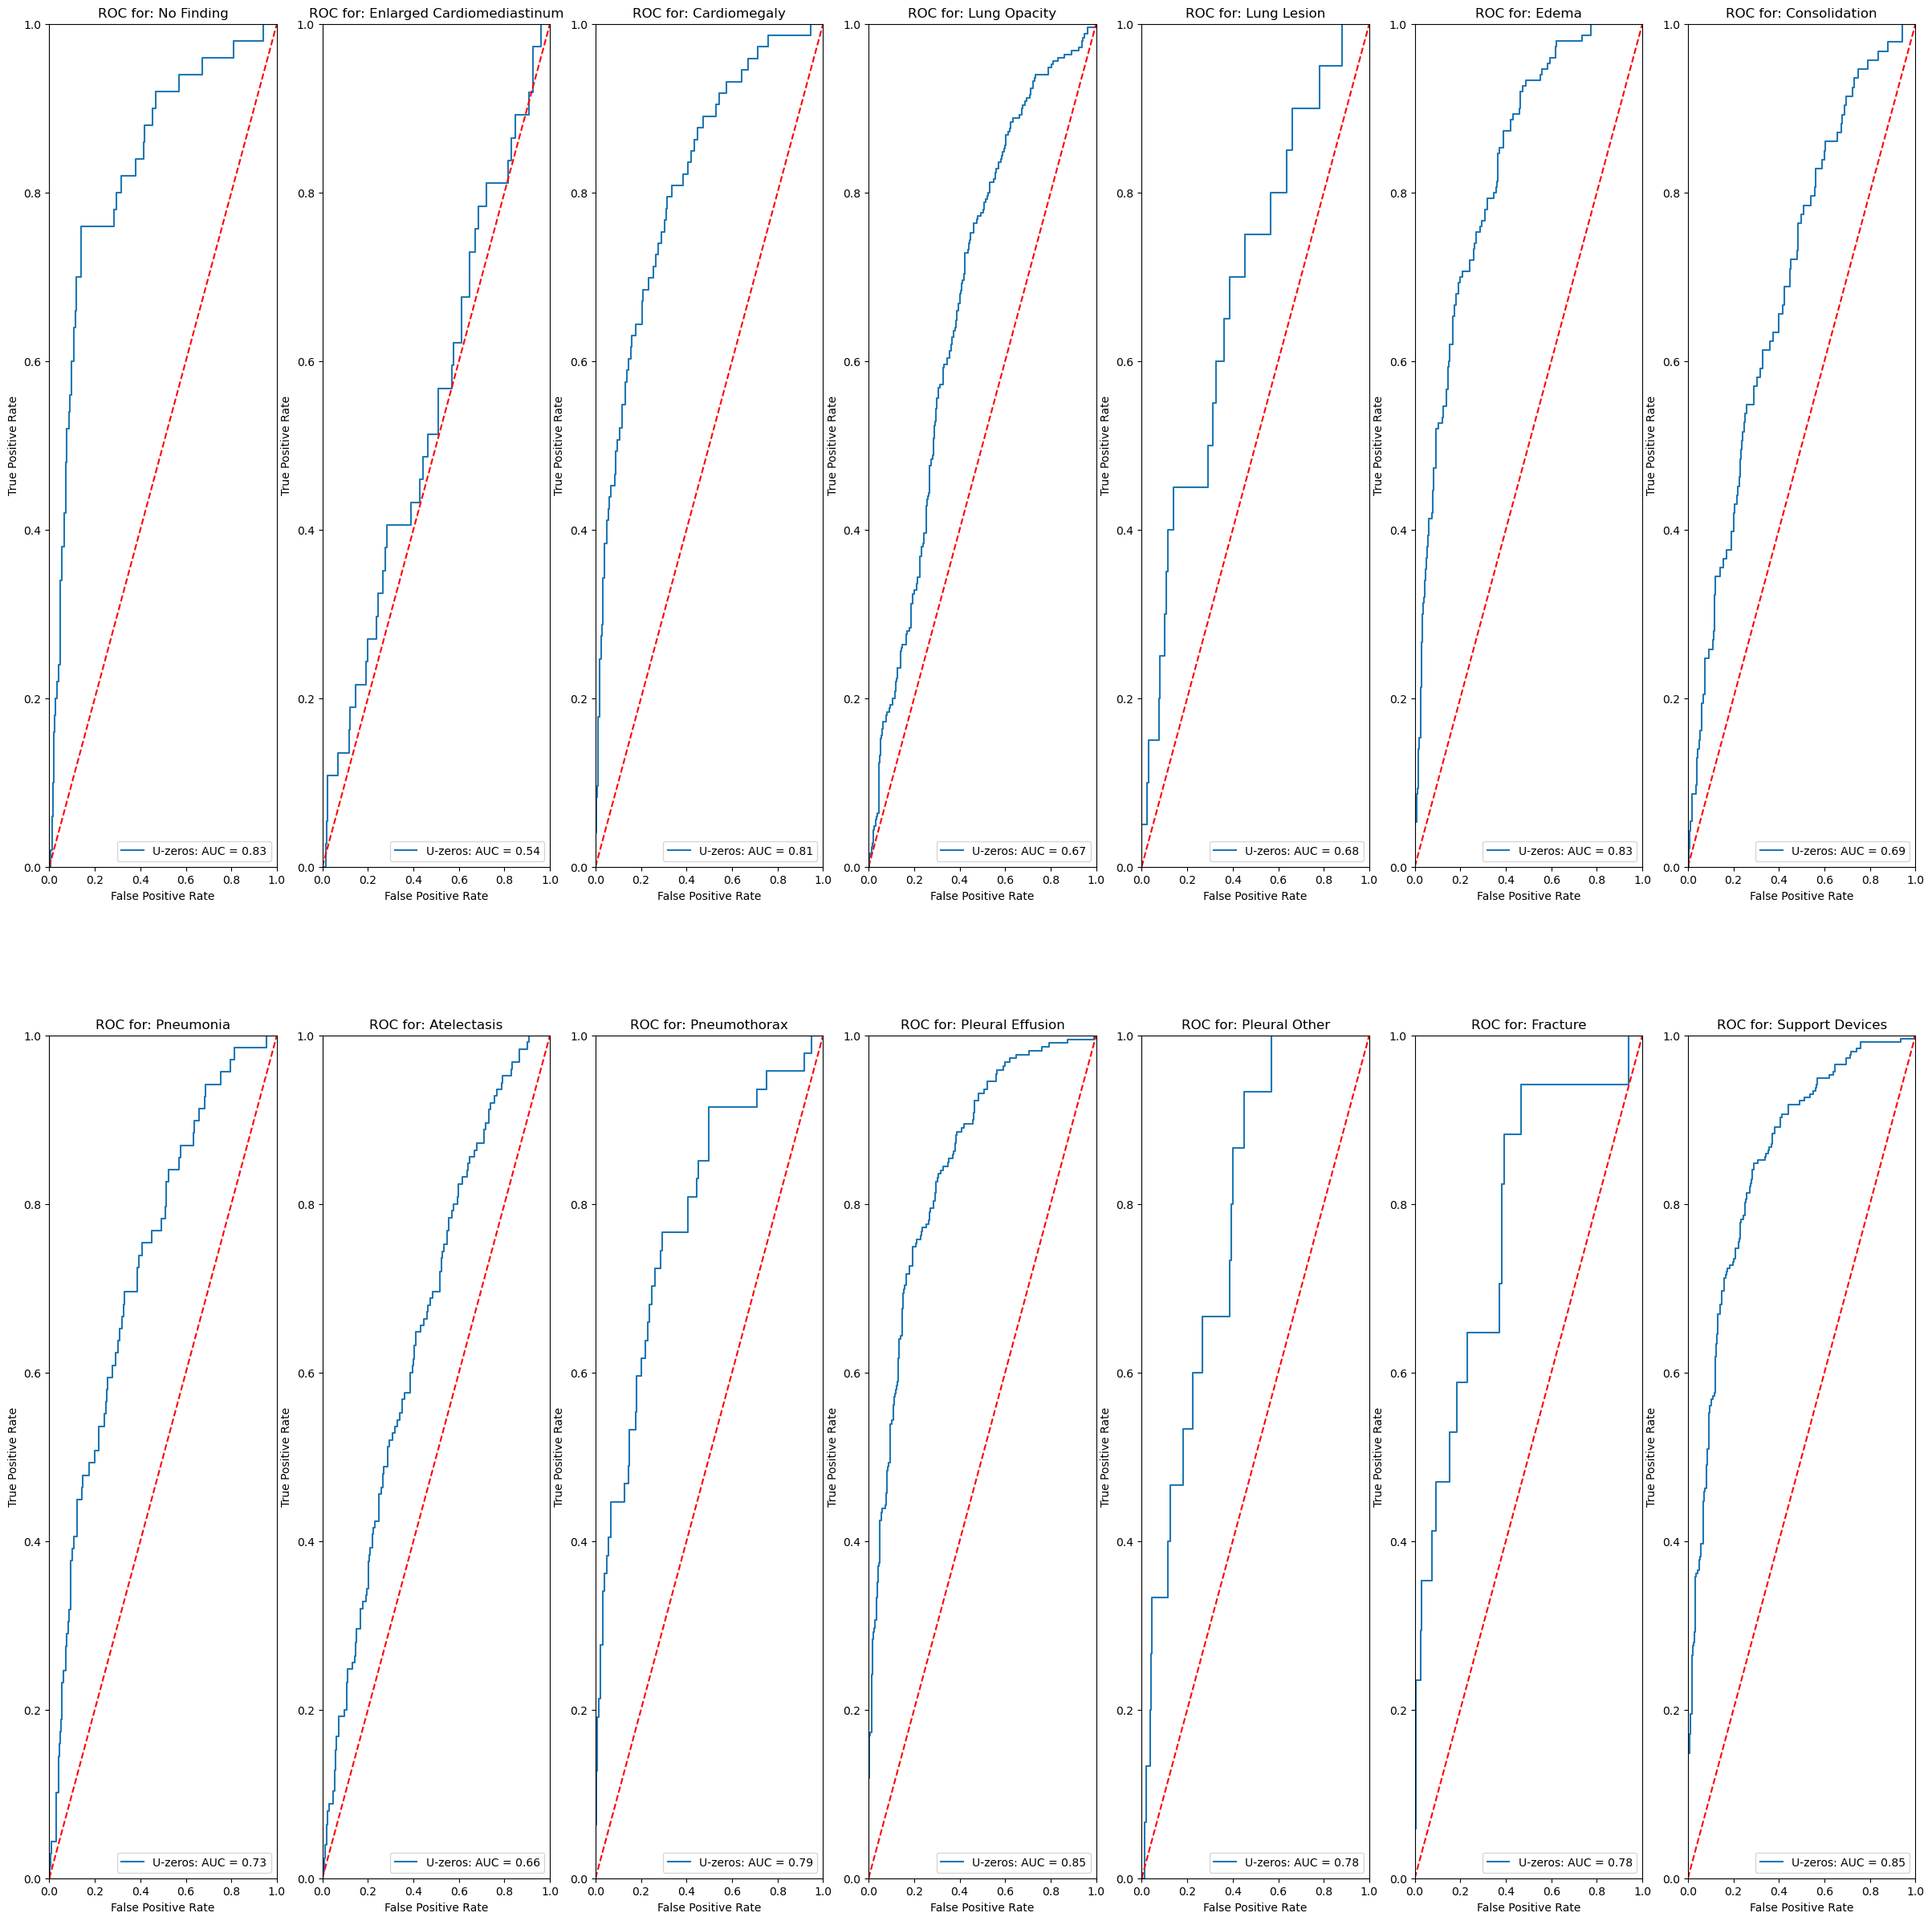

In [16]:
for i in range(nnClassCount):
    fpr, tpr, threshold = metrics.roc_curve(outGT1.cpu()[:,i], outPRED1.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)
    fpr2, tpr2, threshold2 = metrics.roc_curve(outGT3.cpu()[:,i], outPRED3.cpu()[:,i])
    roc_auc2 = metrics.auc(fpr2, tpr2)
    #fpr3, tpr3, threshold2 = metrics.roc_curve(outGT4.cpu()[:,i], outPRED4.cpu()[:,i])
    #roc_auc3 = metrics.auc(fpr3, tpr3)


    plt.title('ROC for: ' + class_names[i])
    #plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)
    plt.plot(fpr2, tpr2, label = 'U-zeros: AUC = %0.2f' % roc_auc2)
    #plt.plot(fpr3, tpr3, label = 'AUC = %0.2f' % roc_auc3)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 30
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

plt.savefig("ROC1345.png", dpi=100)
plt.show()

## 6. Heatmap generator

In [12]:
# class HeatmapGenerator ():
    
#     #---- Initialize heatmap generator
#     #---- pathModel - path to the trained densenet model
#     #---- nnArchitecture - architecture name DENSE-NET121, DENSE-NET169, DENSE-NET201
#     #---- nnClassCount - class count, 14 for chxray-14

 
#     def __init__ (self, pathModel, nnClassCount, transCrop):
       
#         #---- Initialize the network
#         model = DenseNet121(nnClassCount).cuda()
        
#         if use_gpu:
#             model = torch.nn.DataParallel(model).cuda()
#         else:
#             model = torch.nn.DataParallel(model)
        
#         modelCheckpoint = torch.load(pathModel)
#         model.load_state_dict(modelCheckpoint['state_dict'])

#         self.model = model
#         self.model.eval()
        
#         #---- Initialize the weights
#         self.weights = list(self.model.module.densenet121.features.parameters())[-2]

#         #---- Initialize the image transform
#         normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#         transformList = []
#         transformList.append(transforms.Resize((transCrop, transCrop)))
#         transformList.append(transforms.ToTensor())
#         transformList.append(normalize)  
#         self.transformSequence = transforms.Compose(transformList)
    
#     #--------------------------------------------------------------------------------
     
#     def generate (self, pathImageFile, pathOutputFile, transCrop):
        
#         #---- Load image, transform, convert 
#         with torch.no_grad():
 
#             imageData = Image.open(pathImageFile).convert('RGB')
#             imageData = self.transformSequence(imageData)
#             imageData = imageData.unsqueeze_(0)
#             if use_gpu:
#                 imageData = imageData.cuda()
#             l = self.model(imageData)
#             output = self.model.module.densenet121.features(imageData)
#             label = class_names[torch.max(l,1)[1]]
#             #---- Generate heatmap
#             heatmap = None
#             for i in range (0, len(self.weights)):
#                 map = output[0,i,:,:]
#                 if i == 0: heatmap = self.weights[i] * map
#                 else: heatmap += self.weights[i] * map
#                 npHeatmap = heatmap.cpu().data.numpy()

#         #---- Blend original and heatmap 
                
#         imgOriginal = cv2.imread(pathImageFile, 1)
#         imgOriginal = cv2.resize(imgOriginal, (transCrop, transCrop))
        
#         cam = npHeatmap / np.max(npHeatmap)
#         cam = cv2.resize(cam, (transCrop, transCrop))
#         heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
        
#         img = cv2.addWeighted(imgOriginal,1,heatmap,0.35,0)            
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         plt.figure(figsize=(6, 6))  # Ad just figure size
#         plt.title(label)
#         plt.imshow(img)
#         plt.axis('off')
#         plt.savefig(pathOutputFile, dpi=80, bbox_inches='tight')  # Reduce dpi and remove extra margins
#         plt.show()

In [13]:
# pathInputImage = '/scratch/ssriva94/Capstone/archive/image-downsizing-result/view1_frontal.jpg'
# pathOutputImage = '/sscratch/ssriva94/Capstone/archive/image-downsizing-result/heatmap_view1_frontal.png'
# pathModel = "m-epoch0.pth.tar"


# h = HeatmapGenerator(pathModel, nnClassCount, imgtransCrop)

# h.generate(pathInputImage, pathOutputImage, imgtransCrop)

/tmp/ipykernel_2330268/1819199632.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelCheckpoint = torch.load(checkpoint)



Classification Metrics Table:
| Class                      |   Precision |   Recall |   F1 Score |
|:---------------------------|------------:|---------:|-----------:|
| No Finding                 |       0.534 |    0.204 |      0.296 |
| Enlarged Cardiomediastinum |       0     |    0     |      0     |
| Cardiomegaly               |       0.621 |    0.191 |      0.292 |
| Lung Opacity               |       0.64  |    0.671 |      0.655 |
| Lung Lesion                |       0     |    0     |      0     |
| Edema                      |       0.608 |    0.575 |      0.591 |
| Consolidation              |       0.667 |    0     |      0     |
| Pneumonia                  |       0.36  |    0.004 |      0.007 |
| Atelectasis                |       0.554 |    0.047 |      0.087 |
| Pneumothorax               |       0.558 |    0.157 |      0.245 |
| Pleural Effusion           |       0.752 |    0.6   |      0.667 |
| Pleural Other              |       0     |    0     |      0     |
| F

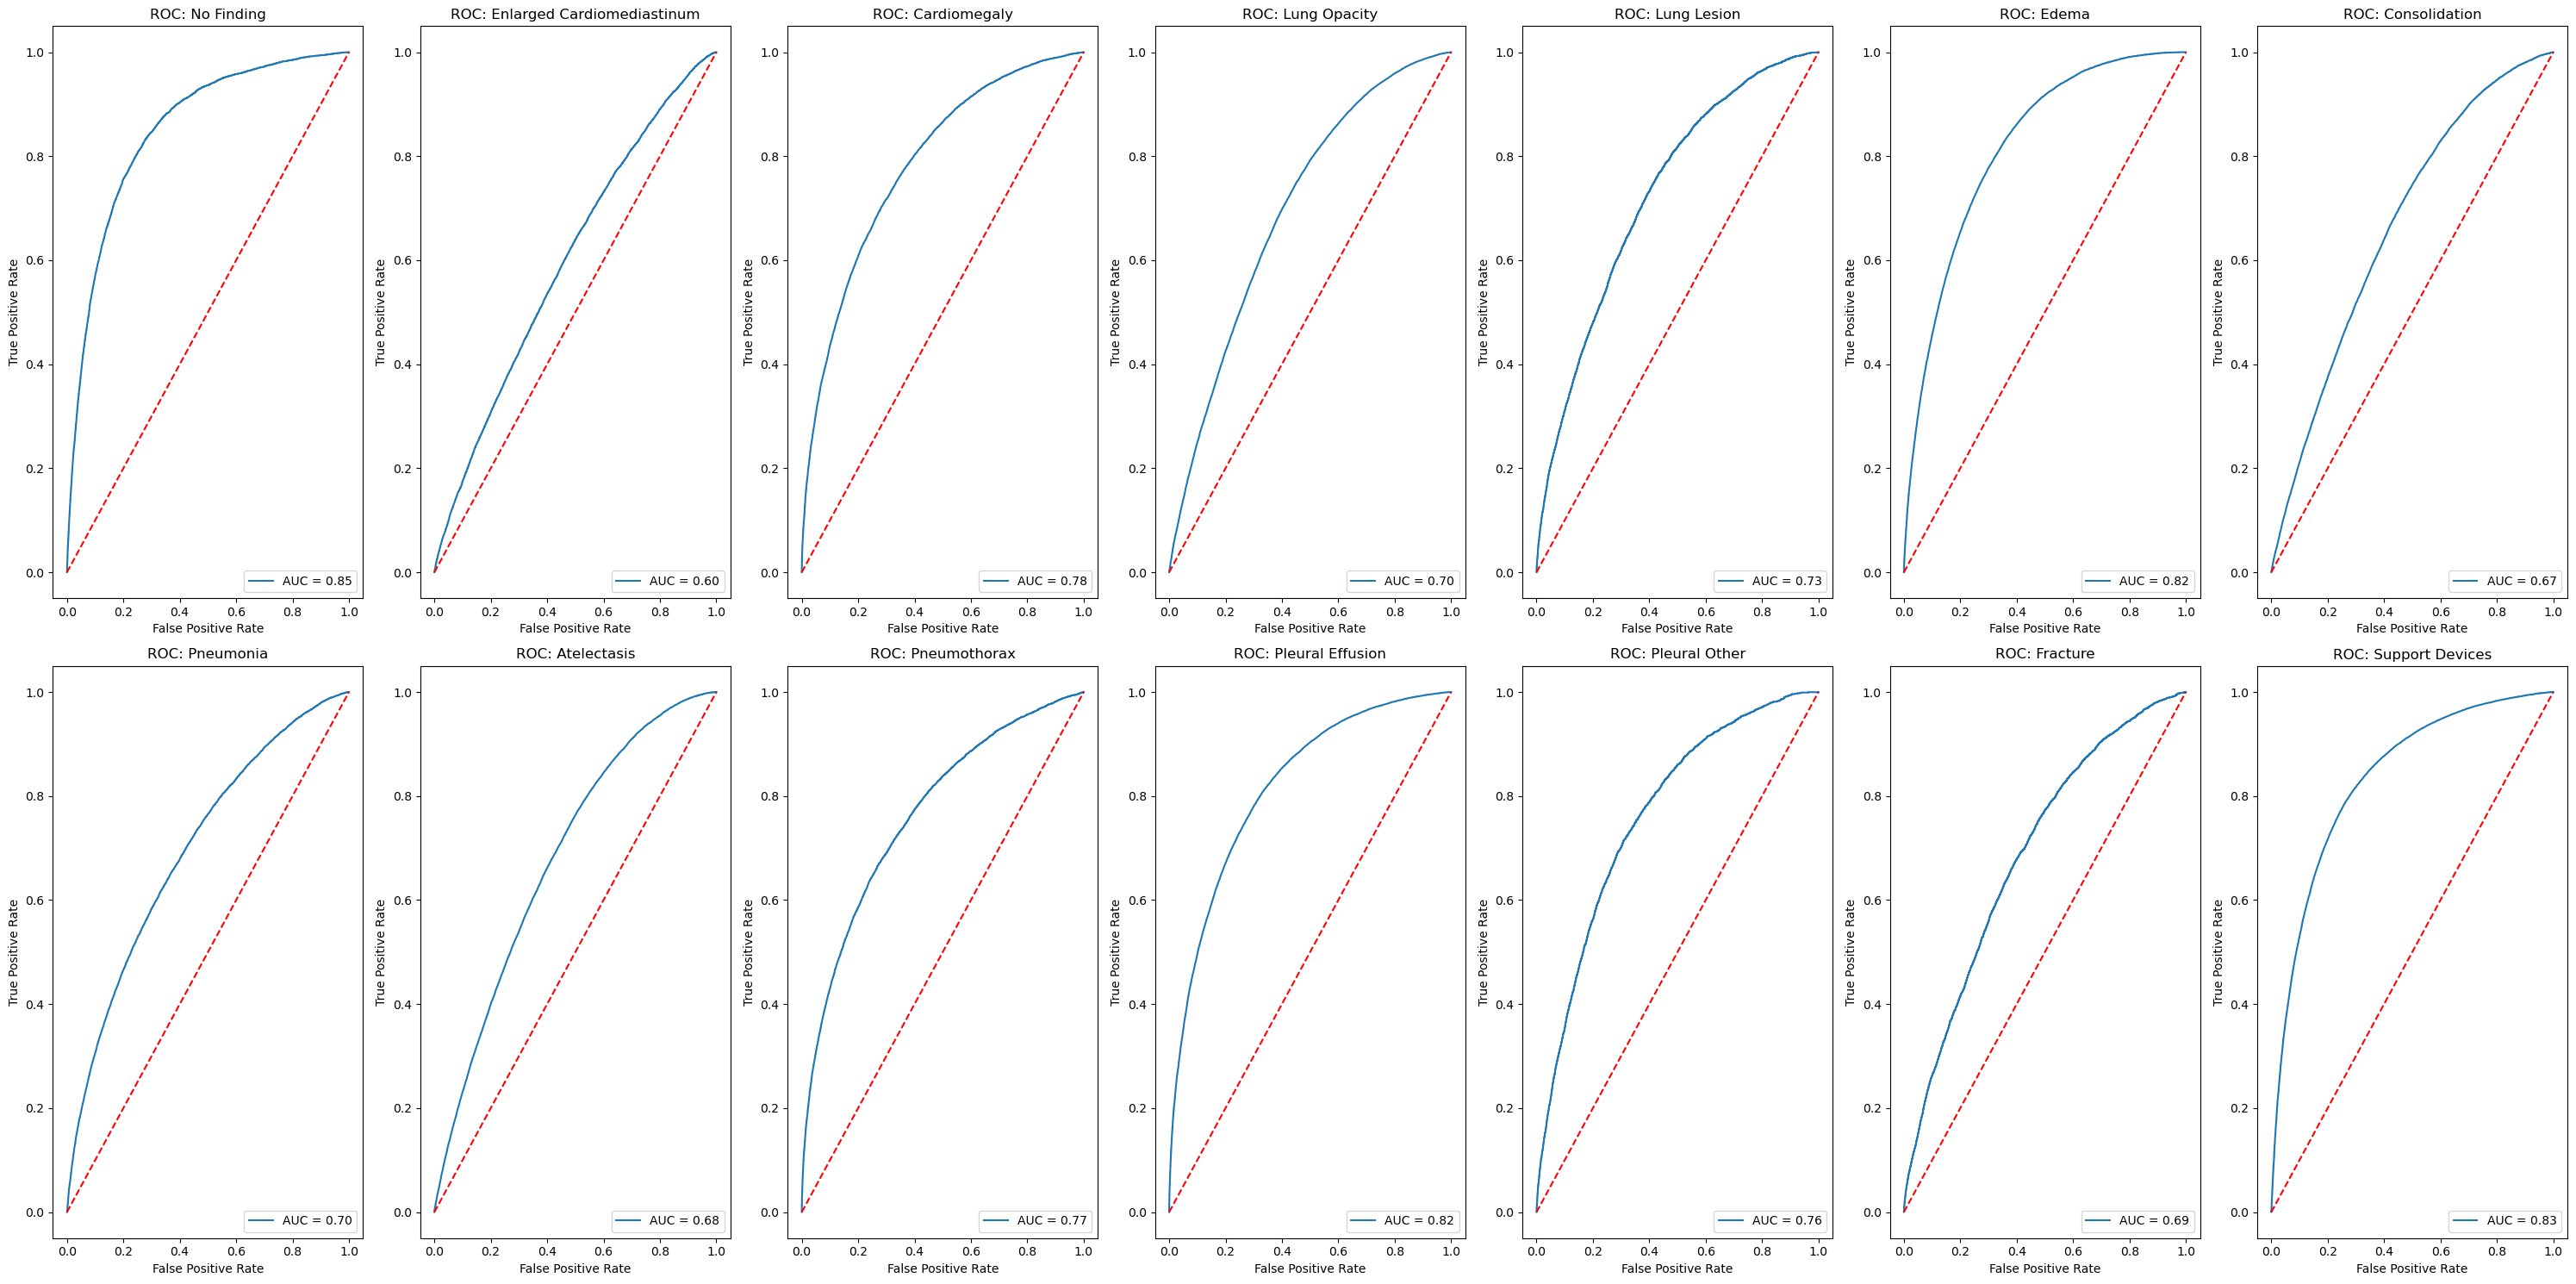

No Finding               : Best Threshold = 0.28, F1 = 0.460
Enlarged Cardiomediastinum: Best Threshold = 0.11, F1 = 0.213
Cardiomegaly             : Best Threshold = 0.24, F1 = 0.455
Lung Opacity             : Best Threshold = 0.28, F1 = 0.702
Lung Lesion              : Best Threshold = 0.07, F1 = 0.187
Edema                    : Best Threshold = 0.39, F1 = 0.621
Consolidation            : Best Threshold = 0.20, F1 = 0.386
Pneumonia                : Best Threshold = 0.14, F1 = 0.303
Atelectasis              : Best Threshold = 0.25, F1 = 0.522
Pneumothorax             : Best Threshold = 0.26, F1 = 0.371
Pleural Effusion         : Best Threshold = 0.34, F1 = 0.723
Pleural Other            : Best Threshold = 0.07, F1 = 0.152
Fracture                 : Best Threshold = 0.10, F1 = 0.150
Support Devices          : Best Threshold = 0.52, F1 = 0.785

Classification Metrics Table:
                     Class  Precision   Recall  F1 Score
                No Finding   0.383492 0.575971  0.460425


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score

# === 1. Define the path to test.csv and create the Test Dataset and Loader ===
pathFileTestNew = '/scratch/ssriva94/Capstone/archive/CheXpert-v1.0-small/test.csv'  # CSV file with test image paths/labels
# Load test dataset using your CheXpertDataSet class and transformSequence
newTestDataset = CheXpertDataSet(pathFileTestNew, transformSequence)
newTestLoader = DataLoader(dataset=newTestDataset, batch_size=trBatchSize, shuffle=False, num_workers=8, pin_memory=True)

# === 2. Run Inference on the Test Dataset ===
checkpoint_path = "m-epoch2.pth.tar"  # Change if needed
outGT_new, outPRED_new = CheXpertTrainer.test(model, newTestLoader, nnClassCount, checkpoint_path, class_names)

# === 3. Begin Evaluation: Prepare Numpy Arrays for Metrics Computation ===
y_true = outGT_new.cpu().numpy()
y_scores = outPRED_new.cpu().numpy()

# === 4. Plot ROC Curves and Compute AUROC for Each Class ===
plt.figure(figsize=(30, 15))
auroc_scores = []
for i in range(len(class_names)):
    try:
        fpr, tpr, _ = metrics.roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc = metrics.auc(fpr, tpr)
        auroc_scores.append(roc_auc)
        
        plt.subplot(2, 7, i + 1)
        plt.title(f'ROC: {class_names[i]}')
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
    except Exception as e:
        auroc_scores.append(0.0)
        print(f"❌ Could not plot ROC for {class_names[i]}: {e}")

plt.tight_layout()
plt.savefig("ROC_new_dataset.png", dpi=300)
plt.show()

# === 5. Compute Optimal Thresholds Based on F1 Score ===
def find_optimal_thresholds(y_true, y_scores, class_names):
    thresholds = []
    for i in range(len(class_names)):
        best_thresh = 0.5
        best_score = 0
        for t in np.arange(0.0, 1.01, 0.01):
            y_pred = (y_scores[:, i] >= t).astype(int)
            score = f1_score(y_true[:, i], y_pred, zero_division=0)
            if score > best_score:
                best_score = score
                best_thresh = t
        thresholds.append(best_thresh)
        print(f"{class_names[i]:<25}: Best Threshold = {best_thresh:.2f}, F1 = {best_score:.3f}")
    return np.array(thresholds)

optimal_thresholds = find_optimal_thresholds(y_true, y_scores, class_names)

# === 6. Binarize Predictions Using the Optimal Thresholds ===
y_pred_opt = np.zeros_like(y_scores)
for i, thresh in enumerate(optimal_thresholds):
    y_pred_opt[:, i] = (y_scores[:, i] >= thresh).astype(int)

# === 7. Create a TP/TN Table (Optional) ===
def get_tp_tn_row(y_true_row, y_pred_row, class_names):
    tp = [class_names[i] for i in range(len(class_names)) if y_true_row[i] == 1 and y_pred_row[i] == 1]
    tn = [class_names[i] for i in range(len(class_names)) if y_true_row[i] == 0 and y_pred_row[i] == 0]
    return ", ".join(tp), ", ".join(tn)

tp_list = []
tn_list = []
for i in range(len(y_true)):
    tp, tn = get_tp_tn_row(y_true[i], y_pred_opt[i], class_names)
    tp_list.append(tp)
    tn_list.append(tn)


# === 8. Generate the Classification Metrics Table ===
metrics_data = []
for i in range(len(class_names)):
    precision = precision_score(y_true[:, i], y_pred_opt[:, i], zero_division=0)
    recall = recall_score(y_true[:, i], y_pred_opt[:, i], zero_division=0)
    f1 = f1_score(y_true[:, i], y_pred_opt[:, i], zero_division=0)
    metrics_data.append([class_names[i], precision, recall, f1])

# Compute Macro and Weighted Averages
macro_precision = precision_score(y_true, y_pred_opt, average='macro', zero_division=0)
macro_recall = recall_score(y_true, y_pred_opt, average='macro', zero_division=0)
macro_f1 = f1_score(y_true, y_pred_opt, average='macro', zero_division=0)
weighted_precision = precision_score(y_true, y_pred_opt, average='weighted', zero_division=0)
weighted_recall = recall_score(y_true, y_pred_opt, average='weighted', zero_division=0)
weighted_f1 = f1_score(y_true, y_pred_opt, average='weighted', zero_division=0)

metrics_data.append(["Macro Average", macro_precision, macro_recall, macro_f1])
metrics_data.append(["Weighted Average", weighted_precision, weighted_recall, weighted_f1])

df_metrics = pd.DataFrame(metrics_data, columns=["Class", "Precision", "Recall", "F1 Score"])
print("\nClassification Metrics Table:")
print(df_metrics.to_string(index=False))
df_metrics.to_csv("classification_metrics_optimal_thresholds.csv", index=False)
print("📄 Classification metrics saved to classification_metrics_optimal_thresholds.csv")

# === 9. AUROC Report ===
print("\nAUROC Scores:")
auroc_report = pd.DataFrame({
    "Class": class_names,
    "AUROC": auroc_scores
})
print(auroc_report.to_string(index=False))
auroc_report.to_csv("auroc_scores.csv", index=False)
print("📄 AUROC scores saved to auroc_scores.csv")
